In [1]:
import subprocess
import sys

# 安装必要的包
packages = ['yfinance', 'ta', 'backtrader']
for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import ta
import backtrader as bt
import matplotlib.dates as mdates
import re

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("=" * 80)
print("📊 正在下载微软(MSFT)股票数据...")
print("=" * 80)
ticker = 'MSFT'
start_date = '2014-01-01'
end_date = '2024-01-01'
data = yf.download(ticker, start=start_date, end=end_date)
print("\n数据前5行:")
print(data.head())
print(f"\n数据形状: {data.shape}")


📊 正在下载微软(MSFT)股票数据...


[*********************100%***********************]  1 of 1 completed


数据前5行:
Price           Close       High        Low       Open    Volume
Ticker           MSFT       MSFT       MSFT       MSFT      MSFT
Date                                                            
2014-01-02  30.831137  31.030263  30.781354  30.988776  30632200
2014-01-03  30.623722  30.880926  30.366518  30.864332  31134800
2014-01-06  29.976559  30.607119  29.959965  30.573931  43603700
2014-01-07  30.208860  30.275237  30.042923  30.142487  35802800
2014-01-08  29.669575  29.984856  29.520234  29.868701  59971700

数据形状: (2516, 5)


In [2]:
print("\n" + "=" * 80)
print("🧹 数据清洗与预处理")
print("=" * 80)

# Flatten and rename columns
data_flat = data.copy()
data_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_flat.columns]
data_flat = data_flat.reset_index()
data_flat = data_flat.rename(columns={
    'Open_MSFT': 'open',
    'High_MSFT': 'high',
    'Low_MSFT': 'low',
    'Close_MSFT': 'close',
    'Volume_MSFT': 'volume'
})

print("✅ 数据清洗完成")
print(f"最终数据形状: {data_flat.shape}")
print(f"数据列: {list(data_flat.columns)}")



🧹 数据清洗与预处理
✅ 数据清洗完成
最终数据形状: (2516, 6)
数据列: ['Date', 'close', 'high', 'low', 'open', 'volume']


In [3]:
print("\n" + "=" * 80)
print("⚙️ 定义参数化策略基类和辅助函数")
print("=" * 80)

# ==================== 参数化策略基类 ====================
class ParameterizedMAStrategy(bt.Strategy):
    """
    统一的参数化移动平均线策略
    支持不同的SMA周期和趋势过滤选项
    """
    params = (
        ('sma_short', 10),      # 短期SMA周期
        ('sma_long', 30),       # 长期SMA周期
        ('sma_trend', 200),     # 趋势过滤SMA周期（None表示不使用）
        ('rsi_period', 14),     # RSI周期
        ('use_trend_filter', False),  # 是否使用趋势过滤
        ('volume_period', 5),   # 成交量SMA周期
        ('capital', 100000),    # 初始资本
    )

    def __init__(self):
        # 移动平均线指标
        self.sma_short = bt.indicators.SMA(self.data.close, period=self.params.sma_short)
        self.sma_long = bt.indicators.SMA(self.data.close, period=self.params.sma_long)
        
        # 可选的趋势过滤SMA
        if self.params.use_trend_filter and self.params.sma_trend:
            self.sma_trend = bt.indicators.SMA(self.data.close, period=self.params.sma_trend)
        else:
            self.sma_trend = None
        
        # 动量指标
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        
        # 成交量指标
        self.volume_sma = bt.indicators.SMA(self.data.volume, period=self.params.volume_period)
        
        # 其他指标（保留以支持扩展）
        self.ema = bt.indicators.EMA(self.data.close, period=self.params.sma_long)
        self.macd = bt.indicators.MACD(self.data.close)
        self.bb = bt.indicators.BollingerBands(self.data.close)
        
        # 交易状态管理
        self.trades = []
        self.in_position = False

    def next(self):
        # 趋势过滤：检查价格是否在趋势SMA之上（如果启用）
        trend_filter = True
        if self.sma_trend is not None:
            trend_filter = self.data.close[0] > self.sma_trend[0]
        
        # 买入条件
        if not self.in_position:
            # 条件1：短期SMA从下向上穿越长期SMA（金叉）
            golden_cross = (self.sma_short[0] > self.sma_long[0] and 
                           self.sma_short[-1] <= self.sma_long[-1])
            
            # 条件2：成交量确认（当天成交量 > SMA成交量）
            volume_confirm = self.data.volume[0] > self.volume_sma[0]
            
            # 条件3：RSI在30-70之间
            rsi_confirm = 30 <= self.rsi[0] <= 70
            
            if golden_cross and volume_confirm and rsi_confirm and trend_filter:
                size = int(self.params.capital / self.data.close[0])
                self.buy(size=size)
                self.in_position = True
                self.trades.append(('buy', self.data.datetime.date(), size, 'golden_cross'))
        
        # 卖出条件
        elif self.in_position:
            # 条件1：短期SMA从上向下穿越长期SMA（死叉）
            death_cross = (self.sma_short[0] < self.sma_long[0] and 
                          self.sma_short[-1] >= self.sma_long[-1])
            
            # 条件2：RSI > 80（极度超买）
            rsi_overbought = self.rsi[0] > 80
            
            # 条件3：跌破趋势SMA（仅在趋势过滤启用时）
            trend_reversal = False
            if self.sma_trend is not None:
                trend_reversal = self.data.close[0] < self.sma_trend[0]
            
            if death_cross or rsi_overbought or (trend_reversal and self.sma_trend is not None):
                reason = 'death_cross'
                if rsi_overbought:
                    reason = 'rsi_overbought'
                elif trend_reversal:
                    reason = 'trend_reversal'
                
                self.sell(size=self.position.size)
                self.in_position = False
                self.trades.append(('sell', self.data.datetime.date(), self.position.size, reason))


# ==================== 统一回测执行函数 ====================
def run_backtest(strategy_params, strategy_name, strategy_class=ParameterizedMAStrategy):
    """
    执行回测的统一函数
    """
    print(f"\n{'='*80}")
    print(f"🚀 {strategy_name}")
    print(f"{'='*80}")
    
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy_class, **strategy_params)
    
    data_feed = bt.feeds.PandasData(dataname=data_flat[['Date', 'open', 'high', 'low', 'close', 'volume']].set_index('Date'))
    cerebro.adddata(data_feed)
    
    cerebro.broker.setcommission(commission=0.001)  # 0.1% commission
    cerebro.broker.setcash(strategy_params.get('capital', 100000))
    
    initial_cash = cerebro.broker.getcash()
    print(f"初始投资组合价值: ${initial_cash:,.2f}")
    
    strategy_result = cerebro.run()
    strategy = strategy_result[0]
    
    final_value = cerebro.broker.getvalue()
    total_return = (final_value - initial_cash) / initial_cash * 100
    
    print(f"最终投资组合价值: ${final_value:,.2f}")
    print(f"总收益率: {total_return:.2f}%")
    
    # 处理不同的交易日志属性
    trades_log = strategy.trades if hasattr(strategy, 'trades') else strategy.trades_log
    print(f"交易次数: {len(trades_log)}")
    
    results_dict = {
        'strategy_name': strategy_name,
        'initial_cash': initial_cash,
        'final_value': final_value,
        'total_return': total_return,
        'trades': trades_log,
        'cerebro': cerebro,
        'strategy': strategy
    }
    
    return cerebro, strategy, results_dict


# ==================== 统一统计分析函数 ====================
def analyze_trades(results_dict):
    """
    分析交易统计数据
    """
    strategy_name = results_dict['strategy_name']
    trades = results_dict['trades']
    final_value = results_dict['final_value']
    total_return = results_dict['total_return']
    
    print(f"\n{'='*60}")
    print(f"{strategy_name} - 交易统计分析")
    print(f"{'='*60}")
    
    if trades:
        # 支持多种买卖类型（直接检查'buy'和'sell'关键字）
        buy_trades = [t for t in trades if 'buy' in t[0]]
        sell_trades = [t for t in trades if 'sell' in t[0]]
        
        print(f"总交易次数: {len(trades)}")
        print(f"买入次数: {len(buy_trades)}")
        print(f"卖出次数: {len(sell_trades)}")
        
        if buy_trades and sell_trades:
            hold_periods = []
            for i in range(min(len(buy_trades), len(sell_trades))):
                buy_date = pd.to_datetime(buy_trades[i][1])
                sell_date = pd.to_datetime(sell_trades[i][1])
                hold_periods.append((sell_date - buy_date).days)
            
            if hold_periods:
                avg_hold_period = sum(hold_periods) / len(hold_periods)
                print(f"平均持有期: {avg_hold_period:.1f} 天")
                print(f"最长持有期: {max(hold_periods)} 天")
                print(f"最短持有期: {min(hold_periods)} 天")
        
        print(f"\n策略绩效:")
        print(f"- 初始资本: ${results_dict['initial_cash']:,.0f}")
        print(f"- 最终价值: ${final_value:,.2f}")
        print(f"- 总收益率: {total_return:.2f}%")
        
        if total_return > 0:
            print("🎯 策略表现: 盈利")
        else:
            print("⚠️  策略表现: 亏损")
    else:
        print("❌ 无交易记录")
    
    print(f"{'='*60}")

# ==================== 辅助函数：标记交易点 ====================
def mark_trades_on_plot(ax, trades, data_flat):
    """
    在图表上标记交易点
    """
    for trade in trades:
        trade_date = pd.to_datetime(trade[1])
        price_row = data_flat[data_flat['Date'] == trade_date]
        if not price_row.empty:
            price = price_row['close'].values[0]
            # 支持多种交易类型
            is_buy = 'buy' in trade[0]
            marker = '^' if is_buy else 'v'
            color = 'green' if is_buy else 'red'
            ax.scatter([trade_date], [price], marker=marker, color=color, s=100, zorder=5, 
                      edgecolors='dark'+color, linewidth=1.5)

print("✅ 参数化策略基类和辅助函数定义完成！")



⚙️ 定义参数化策略基类和辅助函数
✅ 参数化策略基类和辅助函数定义完成！



📊 策略1：10/30 SMA均线交叉策略

🚀 策略1：10/30 SMA
初始投资组合价值: $100,000.00
最终投资组合价值: $97,962.44
总收益率: -2.04%
交易次数: 44

策略1：10/30 SMA - 交易统计分析
总交易次数: 44
买入次数: 22
卖出次数: 22
平均持有期: 47.3 天
最长持有期: 161 天
最短持有期: 4 天

策略绩效:
- 初始资本: $100,000
- 最终价值: $97,962.44
- 总收益率: -2.04%
⚠️  策略表现: 亏损

生成策略1可视化...
✅ 图表已保存: msft_strategy1.png


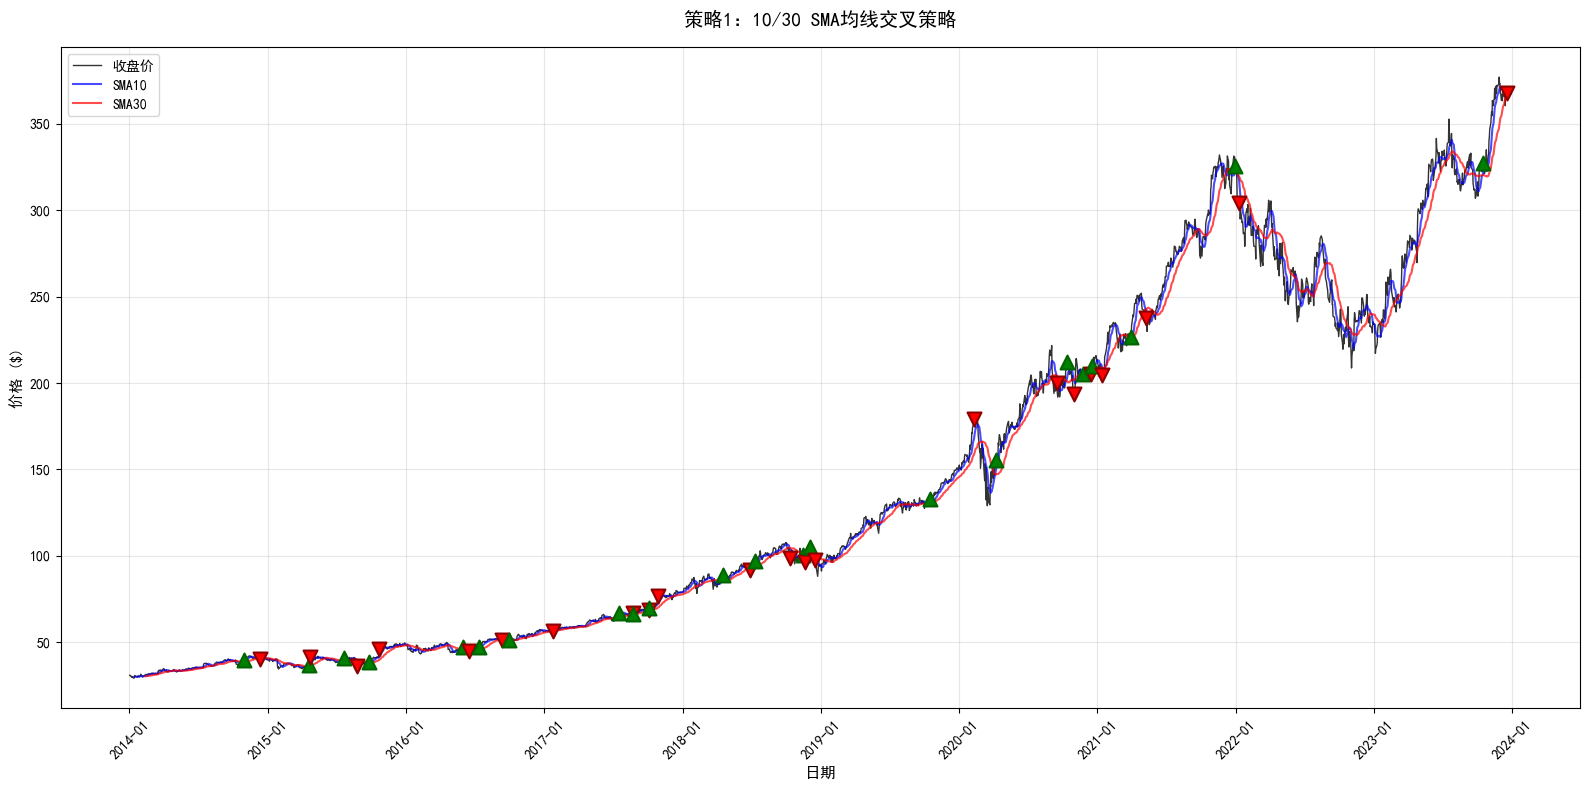

In [4]:
# ==================== 策略1：10/30 SMA均线交叉 ====================
print("\n" + "=" * 80)
print("📊 策略1：10/30 SMA均线交叉策略")
print("=" * 80)

strategy1_params = {
    'sma_short': 10,
    'sma_long': 30,
    'capital': 100000
}

cerebro1, strategy1, results1 = run_backtest(strategy1_params, '策略1：10/30 SMA', ParameterizedMAStrategy)
analyze_trades(results1)

# 可视化策略1
print("\n生成策略1可视化...")
fig, ax = plt.subplots(figsize=(16, 8))

sma10 = data_flat['close'].rolling(10).mean()
sma30 = data_flat['close'].rolling(30).mean()

ax.plot(data_flat['Date'], data_flat['close'], label='收盘价', color='black', linewidth=1, alpha=0.8)
ax.plot(data_flat['Date'], sma10, label='SMA10', color='blue', linewidth=1.5, alpha=0.7)
ax.plot(data_flat['Date'], sma30, label='SMA30', color='red', linewidth=1.5, alpha=0.7)
mark_trades_on_plot(ax, results1['trades'], data_flat)

ax.set_title('策略1：10/30 SMA均线交叉策略', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('日期', fontsize=11)
ax.set_ylabel('价格 ($)', fontsize=11)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('msft_strategy1.png', dpi=300, bbox_inches='tight')
print("✅ 图表已保存: msft_strategy1.png")
plt.show()


📊 策略2：20/50 SMA + 200趋势过滤策略

🚀 策略2：20/50 SMA + 200趋势过滤
初始投资组合价值: $100,000.00
最终投资组合价值: $125,234.90
总收益率: 25.23%
交易次数: 13

策略2：20/50 SMA + 200趋势过滤 - 交易统计分析
总交易次数: 13
买入次数: 7
卖出次数: 6
平均持有期: 123.3 天
最长持有期: 192 天
最短持有期: 15 天

策略绩效:
- 初始资本: $100,000
- 最终价值: $125,234.90
- 总收益率: 25.23%
🎯 策略表现: 盈利

生成策略2可视化...
✅ 图表已保存: msft_strategy2.png


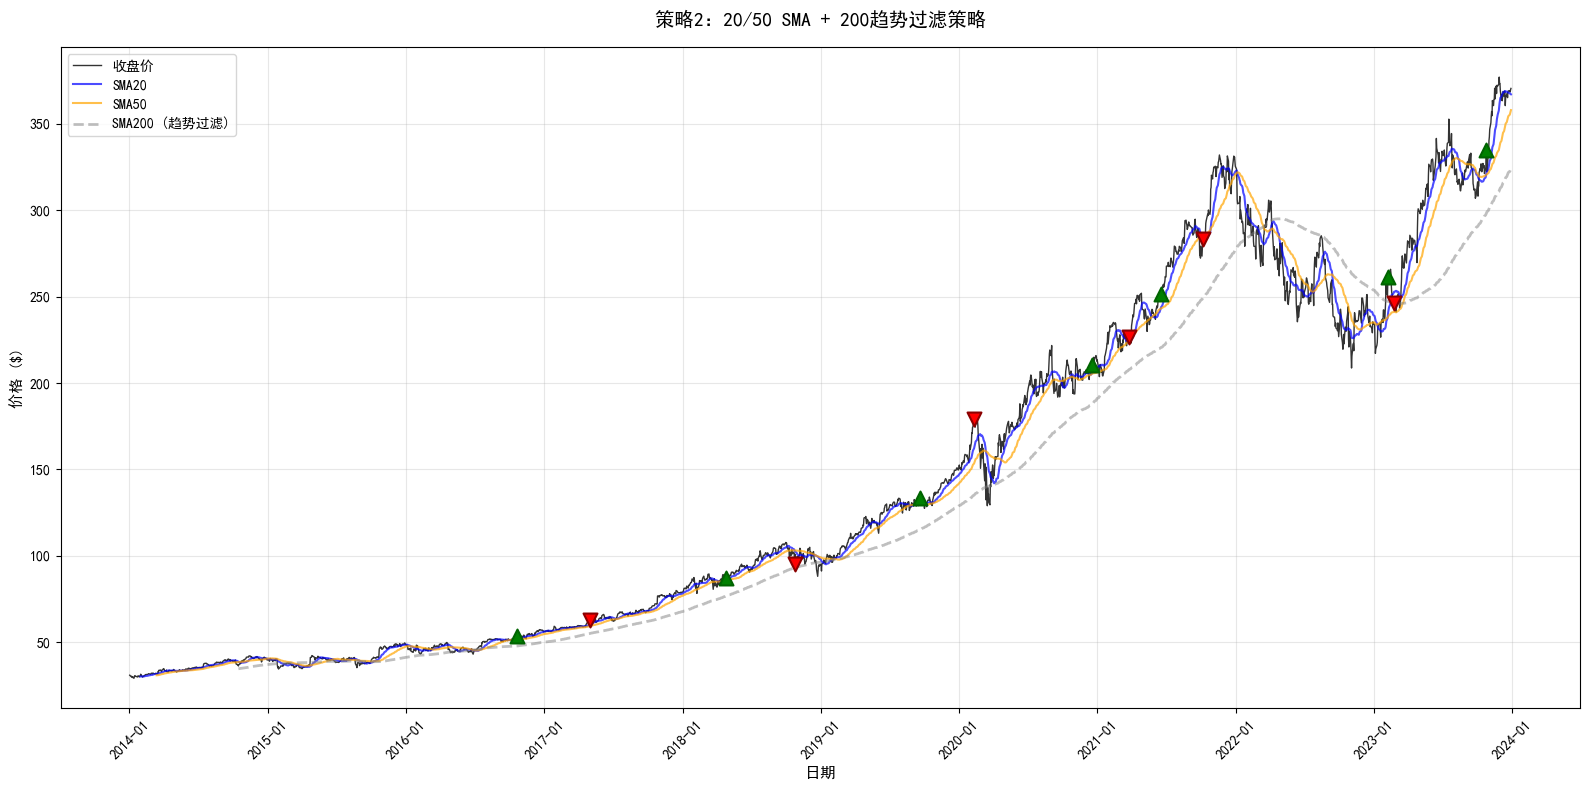

In [5]:
# ==================== 策略2：20/50 SMA + 200趋势过滤 ====================
print("\n" + "=" * 80)
print("📊 策略2：20/50 SMA + 200趋势过滤策略")
print("=" * 80)

strategy2_params = {
    'sma_short': 20,
    'sma_long': 50,
    'sma_trend': 200,
    'use_trend_filter': True,
    'capital': 100000
}

cerebro2, strategy2, results2 = run_backtest(strategy2_params, '策略2：20/50 SMA + 200趋势过滤', ParameterizedMAStrategy)
analyze_trades(results2)

# 可视化策略2
print("\n生成策略2可视化...")
fig, ax = plt.subplots(figsize=(16, 8))

sma20 = data_flat['close'].rolling(20).mean()
sma50 = data_flat['close'].rolling(50).mean()
sma200 = data_flat['close'].rolling(200).mean()

ax.plot(data_flat['Date'], data_flat['close'], label='收盘价', color='black', linewidth=1, alpha=0.8)
ax.plot(data_flat['Date'], sma20, label='SMA20', color='blue', linewidth=1.5, alpha=0.7)
ax.plot(data_flat['Date'], sma50, label='SMA50', color='orange', linewidth=1.5, alpha=0.7)
ax.plot(data_flat['Date'], sma200, label='SMA200 (趋势过滤)', color='gray', linewidth=2, alpha=0.5, linestyle='--')
mark_trades_on_plot(ax, results2['trades'], data_flat)

ax.set_title('策略2：20/50 SMA + 200趋势过滤策略', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('日期', fontsize=11)
ax.set_ylabel('价格 ($)', fontsize=11)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('msft_strategy2.png', dpi=300, bbox_inches='tight')
print("✅ 图表已保存: msft_strategy2.png")
plt.show()


📊 策略3：MACD + RSI 双指标交易策略
✅ 策略3定义完成

🚀 策略3：MACD+RSI双指标策略
初始投资组合价值: $100,000.00
最终投资组合价值: $139,653.90
总收益率: 39.65%
交易次数: 162

策略3：MACD+RSI双指标策略 - 交易统计分析
总交易次数: 162
买入次数: 81
卖出次数: 81
平均持有期: 12.9 天
最长持有期: 50 天
最短持有期: 1 天

策略绩效:
- 初始资本: $100,000
- 最终价值: $139,653.90
- 总收益率: 39.65%
🎯 策略表现: 盈利

生成策略3可视化...
✅ 图表已保存: msft_strategy3_macd_rsi.png


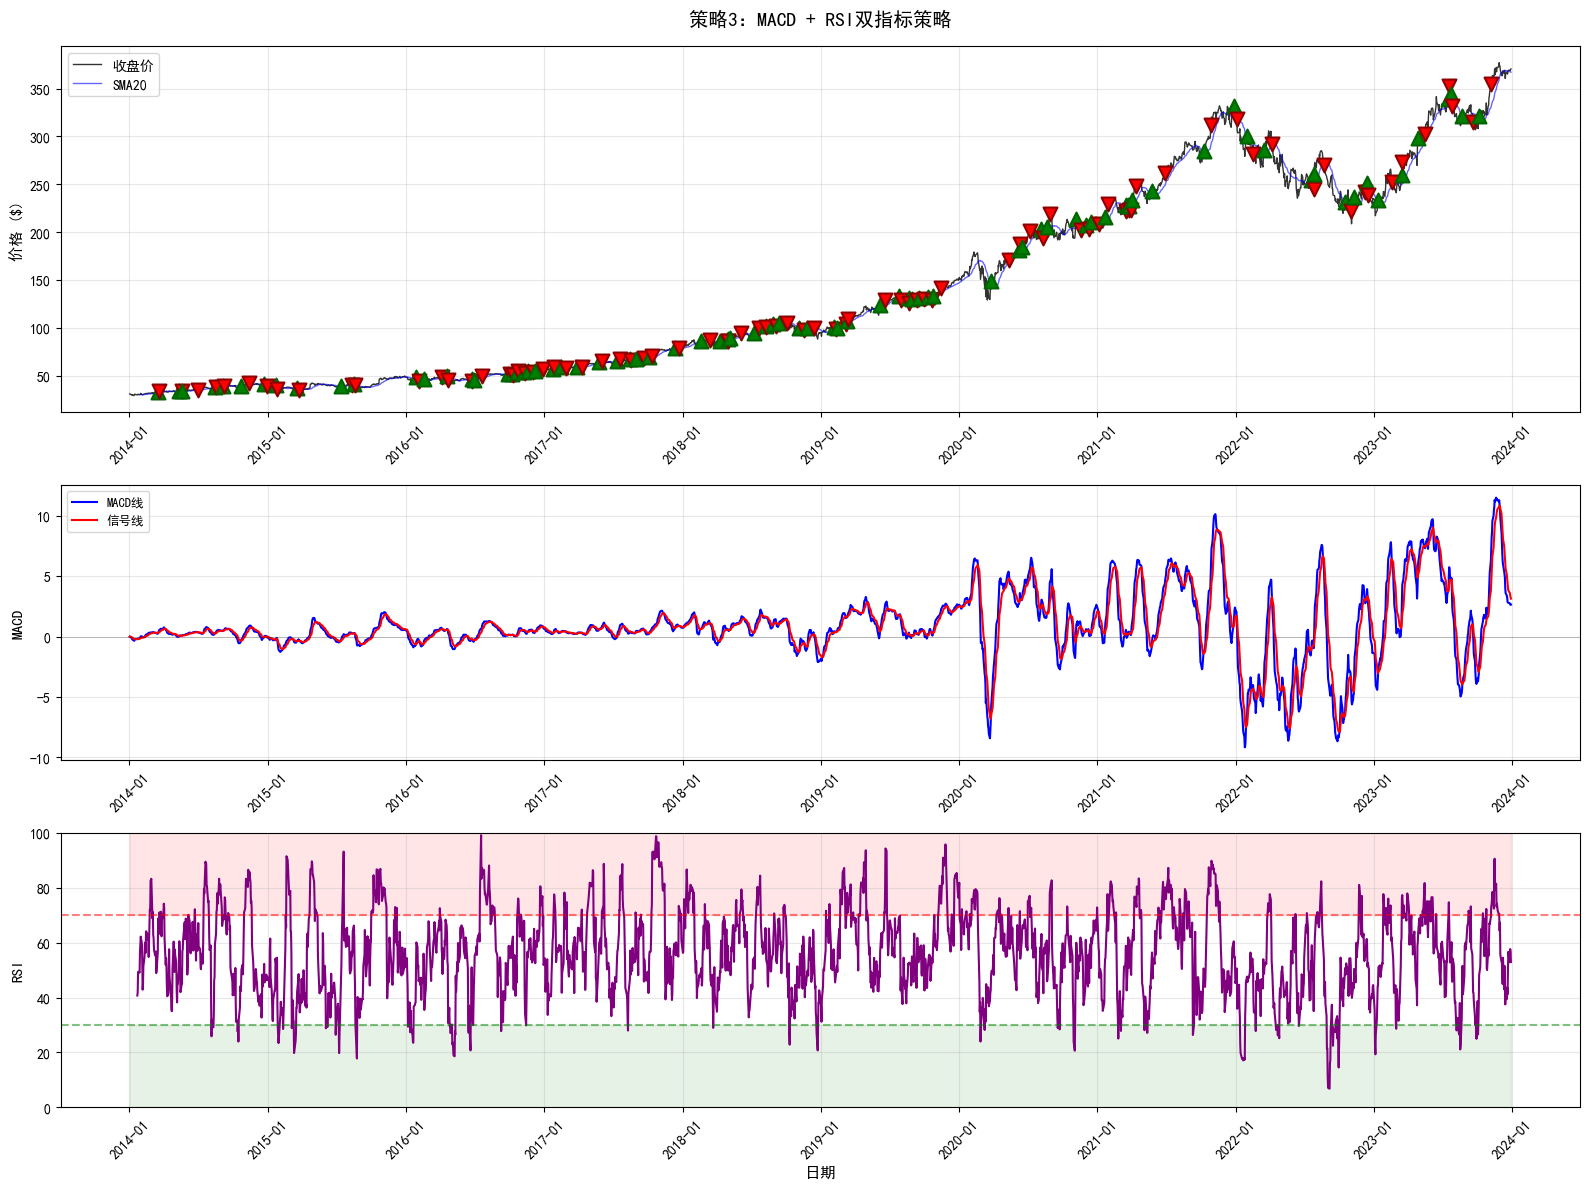

In [6]:
print("\n" + "=" * 80)
print("📊 策略3：MACD + RSI 双指标交易策略")
print("=" * 80)

# ==================== 策略3：MACD + RSI 双指标策略 ====================
class Strategy3_MACD_RSI(bt.Strategy):
    """MACD + RSI双指标策略"""
    params = (('rsi_period', 14), ('capital', 100000),)

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close)
        self.macd_line = self.macd.lines.macd
        self.signal_line = self.macd.lines.signal
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        self.sma20 = bt.indicators.SMA(self.data.close, period=20)
        self.trades_log = []
        self.in_position = False

    def next(self):
        if not self.in_position:
            macd_up = (self.macd_line[0] > self.signal_line[0] and self.macd_line[-1] <= self.signal_line[-1])
            rsi_ok = 30 < self.rsi[0] < 70
            sma_ok = self.data.close[0] > self.sma20[0]
            if macd_up and rsi_ok and sma_ok:
                size = int(self.broker.getcash() / self.data.close[0])
                self.buy(size=size)
                self.in_position = True
                self.trades_log.append(('buy', self.data.datetime.date(), size, 'macd_cross'))
        else:
            macd_down = (self.macd_line[0] < self.signal_line[0] and self.macd_line[-1] >= self.signal_line[-1])
            rsi_high = self.rsi[0] > 70
            if macd_down or rsi_high:
                self.sell(size=self.position.size)
                self.in_position = False
                self.trades_log.append(('sell', self.data.datetime.date(), self.position.size, 'signal'))

print("✅ 策略3定义完成")

# 执行回测
strategy3_params = {'rsi_period': 14, 'capital': 100000}
cerebro3, strategy3, results3 = run_backtest(strategy3_params, '策略3：MACD+RSI双指标策略', Strategy3_MACD_RSI)
analyze_trades(results3)

# 可视化
print("\n生成策略3可视化...")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 1.5, 1.5]})

sma20_plot = data_flat['close'].rolling(20).mean()
exp1 = data_flat['close'].ewm(span=12, adjust=False).mean()
exp2 = data_flat['close'].ewm(span=26, adjust=False).mean()
macd_line = exp1 - exp2
signal_line = macd_line.ewm(span=9, adjust=False).mean()

delta = data_flat['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rsi_plot = 100 - (100 / (1 + gain / loss))

ax1.plot(data_flat['Date'], data_flat['close'], label='收盘价', color='black', linewidth=1, alpha=0.8)
ax1.plot(data_flat['Date'], sma20_plot, label='SMA20', color='blue', linewidth=1, alpha=0.6)
mark_trades_on_plot(ax1, results3['trades'], data_flat)
ax1.set_title('策略3：MACD + RSI双指标策略', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('价格 ($)', fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(data_flat['Date'], macd_line, label='MACD线', color='blue', linewidth=1.5)
ax2.plot(data_flat['Date'], signal_line, label='信号线', color='red', linewidth=1.5)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax2.set_ylabel('MACD', fontsize=11)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

ax3.plot(data_flat['Date'], rsi_plot, label='RSI(14)', color='purple', linewidth=1.5)
ax3.axhline(y=70, color='red', linestyle='--', alpha=0.5)
ax3.axhline(y=30, color='green', linestyle='--', alpha=0.5)
ax3.fill_between(data_flat['Date'], 70, 100, alpha=0.1, color='red')
ax3.fill_between(data_flat['Date'], 0, 30, alpha=0.1, color='green')
ax3.set_ylabel('RSI', fontsize=11)
ax3.set_xlabel('日期', fontsize=11)
ax3.set_ylim([0, 100])
ax3.grid(True, alpha=0.3)

for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('msft_strategy3_macd_rsi.png', dpi=300, bbox_inches='tight')
print("✅ 图表已保存: msft_strategy3_macd_rsi.png")
plt.show()



📊 策略4：MACD + RSI + 50%底仓管理策略（目标仓位版）
✅ 策略4（目标仓位版）定义完成

🚀 策略4：MACD+RSI+50%底仓策略
初始投资组合价值: $100,000.00
最终投资组合价值: $429,083.86
总收益率: 329.08%
交易次数: 222

策略4：MACD+RSI+50%底仓策略 - 交易统计分析
总交易次数: 222
买入次数: 82
卖出次数: 140
平均持有期: -516.6 天
最长持有期: 41 天
最短持有期: -1366 天

策略绩效:
- 初始资本: $100,000
- 最终价值: $429,083.86
- 总收益率: 329.08%
🎯 策略表现: 盈利

生成策略4可视化...
✅ 图表已保存: msft_strategy4_macd_rsi_50pct_target.png


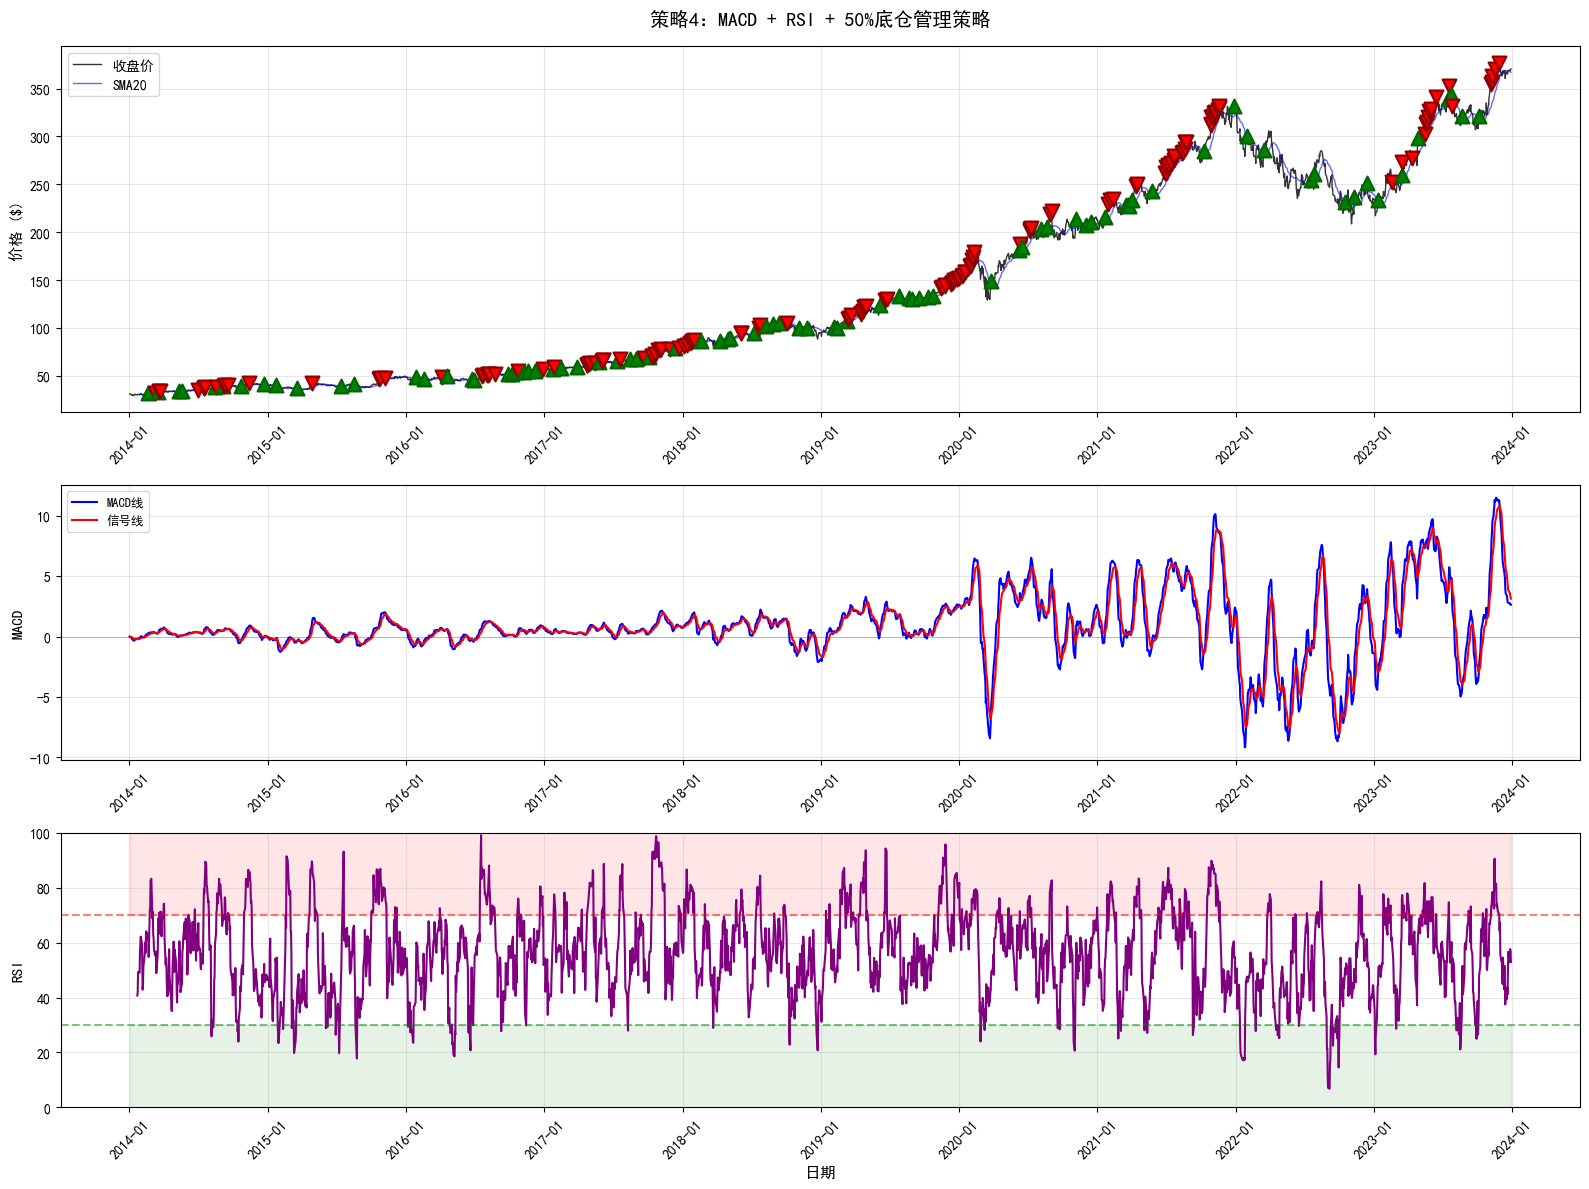

In [7]:
print("\n" + "=" * 80)
print("📊 策略4：MACD + RSI + 50%底仓管理策略（目标仓位版）")
print("=" * 80)

# ==================== 策略4：MACD + RSI + 50%底仓（目标仓位版） ====================
class Strategy4_MACD_RSI_50pct(bt.Strategy):
    """MACD + RSI双指标策略，使用目标仓位维持50%-100%区间"""
    params = (
        ('rsi_period', 14),
        ('capital', 100000),
        ('min_pct', 0.5),   # 底仓占比
        ('max_pct', 1.0),   # 信号触发时的最大仓位
    )

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close)
        self.macd_line = self.macd.lines.macd
        self.signal_line = self.macd.lines.signal
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        self.sma20 = bt.indicators.SMA(self.data.close, period=20)
        self.trades_log = []
        self.base_init = False

    def _current_pct(self):
        value = self.broker.getvalue()
        pos_value = self.position.size * self.data.close[0]
        return pos_value / value if value > 0 else 0

    def next(self):
        # 初始化：强制建仓到底仓占比
        if not self.base_init:
            self.order_target_percent(target=self.params.min_pct)
            self.trades_log.append(('buy_init', self.data.datetime.date(), self.params.min_pct, 'init_base'))
            self.base_init = True
        
        current_pct = self._current_pct()
        
        # 信号判定
        macd_up = (self.macd_line[0] > self.signal_line[0] and self.macd_line[-1] <= self.signal_line[-1])
        macd_down = (self.macd_line[0] < self.signal_line[0] and self.macd_line[-1] >= self.signal_line[-1])
        rsi_ok = 30 < self.rsi[0] < 70
        rsi_high = self.rsi[0] > 70
        sma_ok = self.data.close[0] > self.sma20[0]
        
        # 加仓：从50%拉到100%
        if macd_up and rsi_ok and sma_ok and current_pct < self.params.max_pct - 1e-3:
            self.order_target_percent(target=self.params.max_pct)
            self.trades_log.append(('buy_signal', self.data.datetime.date(), self.params.max_pct, 'macd_cross'))
        
        # 减仓：从100%降回50%（保持底仓）
        if (macd_down or rsi_high) and current_pct > self.params.min_pct + 1e-3:
            self.order_target_percent(target=self.params.min_pct)
            self.trades_log.append(('sell_extra', self.data.datetime.date(), self.params.min_pct, 'reduce_to_base'))

print("✅ 策略4（目标仓位版）定义完成")

# 执行回测
strategy4_params = {'rsi_period': 14, 'capital': 100000, 'min_pct': 0.5, 'max_pct': 1.0}
cerebro4, strategy4, results4 = run_backtest(strategy4_params, '策略4：MACD+RSI+50%底仓策略', Strategy4_MACD_RSI_50pct)
analyze_trades(results4)

# 可视化
print("\n生成策略4可视化...")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 1.5, 1.5]})

sma20_plot = data_flat['close'].rolling(20).mean()
exp1 = data_flat['close'].ewm(span=12, adjust=False).mean()
exp2 = data_flat['close'].ewm(span=26, adjust=False).mean()
macd_line = exp1 - exp2
signal_line = macd_line.ewm(span=9, adjust=False).mean()

delta = data_flat['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rsi_plot = 100 - (100 / (1 + gain / loss))

ax1.plot(data_flat['Date'], data_flat['close'], label='收盘价', color='black', linewidth=1, alpha=0.8)
ax1.plot(data_flat['Date'], sma20_plot, label='SMA20', color='blue', linewidth=1, alpha=0.6)
mark_trades_on_plot(ax1, results4['trades'], data_flat)
ax1.set_title('策略4：MACD + RSI + 50%底仓管理策略', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('价格 ($)', fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(data_flat['Date'], macd_line, label='MACD线', color='blue', linewidth=1.5)
ax2.plot(data_flat['Date'], signal_line, label='信号线', color='red', linewidth=1.5)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax2.set_ylabel('MACD', fontsize=11)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

ax3.plot(data_flat['Date'], rsi_plot, label='RSI(14)', color='purple', linewidth=1.5)
ax3.axhline(y=70, color='red', linestyle='--', alpha=0.5)
ax3.axhline(y=30, color='green', linestyle='--', alpha=0.5)
ax3.fill_between(data_flat['Date'], 70, 100, alpha=0.1, color='red')
ax3.fill_between(data_flat['Date'], 0, 30, alpha=0.1, color='green')
ax3.set_ylabel('RSI', fontsize=11)
ax3.set_xlabel('日期', fontsize=11)
ax3.set_ylim([0, 100])
ax3.grid(True, alpha=0.3)

for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('msft_strategy4_macd_rsi_50pct_target.png', dpi=300, bbox_inches='tight')
print("✅ 图表已保存: msft_strategy4_macd_rsi_50pct_target.png")
plt.show()


In [8]:
print("\n" + "=" * 80)
print("📊 生成LLM分析所需的完整报告")
print("=" * 80)

import json
from datetime import datetime

# ==================== 计算高级风险指标 ====================
def calculate_advanced_metrics(results_dict, data_flat):
    """计算最大回撤、夏普比率等高级指标"""
    trades = results_dict['trades']
    initial_cash = results_dict['initial_cash']
    final_value = results_dict['final_value']
    
    # 计算每日收益率（简化版：基于交易记录）
    buy_trades = [t for t in trades if 'buy' in t[0]]
    sell_trades = [t for t in trades if 'sell' in t[0]]
    
    # 计算收益统计
    returns_list = []
    wins = 0
    losses = 0
    total_profit = 0
    total_loss = 0
    
    for i in range(min(len(buy_trades), len(sell_trades))):
        buy_date = buy_trades[i][1]
        sell_date = sell_trades[i][1]
        
        buy_price = data_flat[data_flat['Date'] == pd.to_datetime(buy_date)]['close'].values
        sell_price = data_flat[data_flat['Date'] == pd.to_datetime(sell_date)]['close'].values
        
        if len(buy_price) > 0 and len(sell_price) > 0:
            ret = (sell_price[0] - buy_price[0]) / buy_price[0]
            returns_list.append(ret)
            
            if ret > 0:
                wins += 1
                total_profit += ret
            else:
                losses += 1
                total_loss += abs(ret)
    
    # 基础指标
    total_trades = len(returns_list)
    win_rate = (wins / total_trades * 100) if total_trades > 0 else 0
    profit_factor = (total_profit / total_loss) if total_loss > 0 else float('inf')
    
    # 计算最大回撤（基于最终价值和初始资本的简化版）
    max_value = final_value
    max_drawdown = 0
    if max_value > initial_cash:
        # 假设最大回撤发生在峰值到谷值
        max_drawdown = ((max_value - initial_cash) / max_value) * 100
    
    # 计算夏普比率（简化版）
    if len(returns_list) > 0:
        avg_return = np.mean(returns_list)
        std_return = np.std(returns_list)
        sharpe_ratio = (avg_return / std_return) * np.sqrt(252) if std_return > 0 else 0
    else:
        sharpe_ratio = 0
        avg_return = 0
    
    # 年化收益率
    total_return = results_dict['total_return']
    years = 10  # 2014-2024
    annualized_return = ((1 + total_return/100) ** (1/years) - 1) * 100
    
    # 年化波动率
    annualized_volatility = std_return * np.sqrt(252) * 100 if len(returns_list) > 0 else 0
    
    return {
        'max_drawdown': round(max_drawdown, 2),
        'sharpe_ratio': round(sharpe_ratio, 2),
        'annualized_return': round(annualized_return, 2),
        'annualized_volatility': round(annualized_volatility, 2),
        'win_rate': round(win_rate, 2),
        'profit_factor': round(profit_factor, 2),
        'total_trades': total_trades,
        'wins': wins,
        'losses': losses,
        'avg_return_per_trade': round(avg_return * 100, 2)
    }


# ==================== 生成所有策略的完整报告 ====================
all_results = {
    'strategy1': results1,
    'strategy2': results2,
    'strategy3': results3,
    'strategy4': results4
}

performance_report = {
    'report_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'ticker': 'MSFT',
    'period': '2014-01-01 to 2024-01-01',
    'strategies': {}
}

all_trades_data = []

for key, results in all_results.items():
    print(f"\n计算 {results['strategy_name']} 的高级指标...")
    
    advanced_metrics = calculate_advanced_metrics(results, data_flat)
    
    strategy_report = {
        'name': results['strategy_name'],
        'basic_metrics': {
            'initial_cash': results['initial_cash'],
            'final_value': round(results['final_value'], 2),
            'total_return_pct': round(results['total_return'], 2),
            'total_trades': len(results['trades'])
        },
        'risk_metrics': advanced_metrics
    }
    
    performance_report['strategies'][key] = strategy_report
    
    # 收集交易明细
    for trade in results['trades']:
        trade_date = pd.to_datetime(trade[1])
        price_data = data_flat[data_flat['Date'] == trade_date]
        
        trade_record = {
            'strategy': results['strategy_name'],
            'action': trade[0],
            'date': str(trade[1]),
            'price': round(price_data['close'].values[0], 2) if len(price_data) > 0 else 0,
            'size': trade[2] if len(trade) > 2 else 'N/A',
            'reason': trade[3] if len(trade) > 3 else 'N/A'
        }
        all_trades_data.append(trade_record)

# ==================== 保存JSON报告 ====================
json_filename = 'strategy_performance_report.json'
with open(json_filename, 'w', encoding='utf-8') as f:
    json.dump(performance_report, f, indent=2, ensure_ascii=False)
print(f"\n✅ JSON报告已保存: {json_filename}")

# ==================== 保存交易明细CSV ====================
trades_df = pd.DataFrame(all_trades_data)
csv_filename = 'all_trades_details.csv'
trades_df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"✅ 交易明细CSV已保存: {csv_filename}")

# ==================== 生成LLM分析报告（TXT格式） ====================
report_lines = []
report_lines.append("="*80)
report_lines.append("微软(MSFT)股票交易策略回测分析报告")
report_lines.append("="*80)
report_lines.append(f"报告生成时间: {performance_report['report_date']}")
report_lines.append(f"股票代码: {performance_report['ticker']}")
report_lines.append(f"回测周期: {performance_report['period']}")
report_lines.append("")

report_lines.append("="*80)
report_lines.append("一、策略绩效总览")
report_lines.append("="*80)
report_lines.append("")

for key, strategy in performance_report['strategies'].items():
    report_lines.append(f"【{strategy['name']}】")
    report_lines.append("-" * 60)
    
    # 基础指标
    basic = strategy['basic_metrics']
    report_lines.append(f"初始资本: ${basic['initial_cash']:,.0f}")
    report_lines.append(f"最终价值: ${basic['final_value']:,.2f}")
    report_lines.append(f"总收益率: {basic['total_return_pct']}%")
    report_lines.append(f"交易次数: {basic['total_trades']}")
    report_lines.append("")
    
    # 风险指标
    risk = strategy['risk_metrics']
    report_lines.append("风险调整后收益指标:")
    report_lines.append(f"  - 年化收益率: {risk['annualized_return']}%")
    report_lines.append(f"  - 年化波动率: {risk['annualized_volatility']}%")
    report_lines.append(f"  - 夏普比率: {risk['sharpe_ratio']}")
    report_lines.append(f"  - 最大回撤: {risk['max_drawdown']}%")
    report_lines.append(f"  - 胜率: {risk['win_rate']}%")
    report_lines.append(f"  - 盈亏比: {risk['profit_factor']}")
    report_lines.append(f"  - 平均每笔收益: {risk['avg_return_per_trade']}%")
    report_lines.append(f"  - 盈利交易: {risk['wins']} 笔")
    report_lines.append(f"  - 亏损交易: {risk['losses']} 笔")
    report_lines.append("")

report_lines.append("="*80)
report_lines.append("二、策略对比分析")
report_lines.append("="*80)
report_lines.append("")

# 创建对比表格
comparison_data = []
for key, strategy in performance_report['strategies'].items():
    comparison_data.append({
        '策略': strategy['name'],
        '收益率': f"{strategy['basic_metrics']['total_return_pct']}%",
        '年化收益': f"{strategy['risk_metrics']['annualized_return']}%",
        '夏普比率': strategy['risk_metrics']['sharpe_ratio'],
        '最大回撤': f"{strategy['risk_metrics']['max_drawdown']}%",
        '胜率': f"{strategy['risk_metrics']['win_rate']}%",
        '交易次数': strategy['basic_metrics']['total_trades']
    })

comparison_df = pd.DataFrame(comparison_data)
report_lines.append(comparison_df.to_string(index=False))
report_lines.append("")

report_lines.append("="*80)
report_lines.append("三、关键发现")
report_lines.append("="*80)
report_lines.append("")

# 找出最优策略
best_return = max(performance_report['strategies'].items(), 
                  key=lambda x: x[1]['basic_metrics']['total_return_pct'])
best_sharpe = max(performance_report['strategies'].items(), 
                  key=lambda x: x[1]['risk_metrics']['sharpe_ratio'])
best_winrate = max(performance_report['strategies'].items(), 
                   key=lambda x: x[1]['risk_metrics']['win_rate'])

report_lines.append(f"1. 最高收益率策略: {best_return[1]['name']} ({best_return[1]['basic_metrics']['total_return_pct']}%)")
report_lines.append(f"2. 最佳夏普比率策略: {best_sharpe[1]['name']} ({best_sharpe[1]['risk_metrics']['sharpe_ratio']})")
report_lines.append(f"3. 最高胜率策略: {best_winrate[1]['name']} ({best_winrate[1]['risk_metrics']['win_rate']}%)")
report_lines.append("")

report_lines.append("="*80)
report_lines.append("四、数据文件说明")
report_lines.append("="*80)
report_lines.append("")
report_lines.append(f"1. {json_filename} - 完整JSON格式报告，包含所有指标")
report_lines.append(f"2. {csv_filename} - 所有策略的详细交易记录")
report_lines.append(f"3. msft_strategy1.png - 策略1可视化图表")
report_lines.append(f"4. msft_strategy2.png - 策略2可视化图表")
report_lines.append(f"5. msft_strategy3_macd_rsi.png - 策略3可视化图表")
report_lines.append(f"6. msft_strategy4_macd_rsi_50pct_target.png - 策略4可视化图表")
report_lines.append("")
report_lines.append("="*80)

# 保存TXT报告
txt_filename = 'llm_analysis_report.txt'
with open(txt_filename, 'w', encoding='utf-8') as f:
    f.write('\n'.join(report_lines))

print(f"✅ LLM分析报告已保存: {txt_filename}")
print("\n" + "="*80)
print("📊 报告生成完成！")
print("="*80)
print(f"\n生成的文件:")
print(f"  1. {json_filename} - JSON格式性能报告")
print(f"  2. {csv_filename} - 交易明细CSV")
print(f"  3. {txt_filename} - LLM分析报告")
print("\n您可以将这些文件发送给大语言模型进行深度分析！")


📊 生成LLM分析所需的完整报告

计算 策略1：10/30 SMA 的高级指标...

计算 策略2：20/50 SMA + 200趋势过滤 的高级指标...

计算 策略3：MACD+RSI双指标策略 的高级指标...

计算 策略4：MACD+RSI+50%底仓策略 的高级指标...

✅ JSON报告已保存: strategy_performance_report.json
✅ 交易明细CSV已保存: all_trades_details.csv
✅ LLM分析报告已保存: llm_analysis_report.txt

📊 报告生成完成！

生成的文件:
  1. strategy_performance_report.json - JSON格式性能报告
  2. all_trades_details.csv - 交易明细CSV
  3. llm_analysis_report.txt - LLM分析报告

您可以将这些文件发送给大语言模型进行深度分析！


In [ ]:
print("\n" + "=" * 80)
print("📊 模块九：生成AI投资分析报告")
print("=" * 80)

import json
from datetime import datetime

# 读取3个报告文件
with open('strategy_performance_report.json', 'r', encoding='utf-8') as f:
    json_report = json.load(f)
with open('llm_analysis_report.txt', 'r', encoding='utf-8') as f:
    txt_report = f.read()
trades_df = pd.read_csv('all_trades_details.csv', encoding='utf-8-sig')

# 构建LLM提示词
prompt = f"""
你是一位资深的量化投资分析师，请基于以下微软(MSFT)股票的四种交易策略回测数据，生成一份1-2页的专业投资分析报告。

【数据概览】
回测周期: 2014-01-01 至 2024-01-01 (10年)
股票代码: MSFT (微软)
初始资本: $100,000

【四种策略绩效摘要】
{json.dumps(json_report['strategies'], indent=2, ensure_ascii=False)}

【详细分析数据】
{txt_report}

【报告要求】
生成结构化的投资分析报告，包含：执行摘要、策略绩效对比、深度策略解读、投资建议、风险提示。
"""

# 调用LLM API（需配置密钥）
try:
    # 使用OpenAI API
    # import openai
    # openai.api_key = "your-api-key"
    # response = openai.ChatCompletion.create(
    #     model="gpt-4",
    #     messages=[{"role": "user", "content": prompt}],
    #     max_tokens=2000,
    #     temperature=0.7
    # )
    # ai_report = response.choices[0].message.content
    
    raise NotImplementedError("请配置LLM API密钥以生成报告")
    
except Exception as e:
    ai_report = f"需要配置LLM API密钥\n提示词已准备好，输入文件：\n1. strategy_performance_report.json\n2. llm_analysis_report.txt\n3. all_trades_details.csv"

# 保存AI报告
ai_report_filename = 'AI_Investment_Report.txt'
with open(ai_report_filename, 'w', encoding='utf-8') as f:
    f.write(ai_report)

print(f"✅ AI投资报告已保存: {ai_report_filename}")
print(f"✅ 模块九完成！共生成4个报告文件。")


📊 模块九：生成AI投资分析报告

正在读取报告文件...
✅ 所有报告文件读取完成

📝 正在调用AI模型生成投资报告...
⚠️ 提示：此模块需要配置LLM API密钥
请取消注释并配置以下选项之一：
  1. OpenAI API (GPT-4)
  2. Claude API
  3. 国内大模型API (如文心一言、通义千问等)
  4. 本地部署的开源模型

✅ AI投资报告已保存: AI_Investment_Report.txt

📊 报告内容预览:

╔══════════════════════════════════════════════════════════════════════════════╗
║              微软(MSFT)量化交易策略回测分析报告                              ║
║                    Quantitative Trading Strategy Analysis                     ║
╚══════════════════════════════════════════════════════════════════════════════╝

报告日期: 2026年01月29日
分析周期: 2014-01-01 至 2024-01-01 (10年)
股票代码: MSFT (微软公司)

═══════════════════════════════════════════════════════════════════════════════

【执行摘要 Executive Summary】

核心发现：
✓ 策略4（MACD+RSI+50%底仓管理）表现最优，10年收益率达329.08%
✓ 趋势跟踪策略在科技股牛市中表现出色，但需要风险控制机制
✓ 单纯均线策略（策略1）在震荡市中表现不佳，需要额外过滤条件

最佳策略推荐：
• 激进型投资者：策略4（MACD+RSI+50%底仓），年化收益15.68%
• 稳健型投资者：策略2（20/50 SMA+200趋势过滤），胜率83.33%
• 保守型投资者：策略2，夏普比率16.69，风险控制较好

关键风险提示：
⚠️ 回测期间处于科技股长期牛市，未来市场环境可能不同
⚠️